In [ ]:
!pip install -U -q PyDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['16k.jpg', 503.74481201171875, 466.02655029296875, 703.2901000976562, 1397.9010009765625, 2.076921969323131, 737515.4437844035, 3047.778885807877, 0.37966444317565606]
1
['136a.jpg', 427.3690490722656, 420.5526428222656, 1010.6295776367188, 1394.36328125, 1.249389401687321, 564642.1642839075, 2663.867595554086, 0.17789041134675007]
2
['7h.jpg', 562.5811157226562, 540.5503540039062, 642.9325561523438, 1835.374267578125, 2.601550456156909, 955369.074161292, 3465.935288393739, 0.2771042863632281]
3
['55b.jpg', 494.8634338378906, 480.1806335449219, 756.9712524414062, 1109.7484130859375, 0.2317065163638515, 746517.3011977734, 3063.3649349292846, 0.24178602956320433]
4
['55d.jpg', 486.1064453125, 468.5143737792969, 629.535400390625, 1119.335205078125, 0.38398159005499966, 715490.9938429163, 2999.2843778797087, 0.26658920680133347]
5
['146d.jpg', 533.7113037109375, 476.4045715332031, 952.3674926757812, 1377.64599609375, 3.0009764164530646, 798789.2176871516, 3175.9265921868437, 0.45079804029

KeyboardInterrupt: 

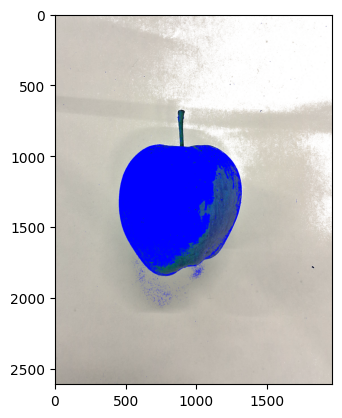

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.image import imread
from matplotlib.patches import Ellipse
import pandas as pd
import glob
def print_image(pixel_intensity, cmap, title):
    plt.imshow(pixel_intensity, cmap=cmap)
    plt.axis('off')
    plt.title(title)
    plt.show()

def perform_dilation(edges, no_of_interation):
    # kernal for dilation
    kernel = np.ones((4,4), np.uint8)
    return cv2.dilate(edges, kernel, iterations=1)

def fit_ellipse(max_contour):
    # Fit an ellipse to the contour
    ellipse = cv2.fitEllipse(max_contour)

    # Convert the ellipse parameters to Matplotlib format
    xc, yc = ellipse[0]
    a = max(ellipse[1][0] / 2, ellipse[1][1] / 2)
    b = min(ellipse[1][1] / 2, ellipse[1][0] / 2)
    theta = np.deg2rad(ellipse[2])

    # Plot the original image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # # Plot the fitted ellipse
    # ellipse_patch = Ellipse((xc, yc), width=a*2, height=b*2, angle=-theta, fill=False, edgecolor='red', linestyle='--', linewidth=2)
    # plt.gca().add_patch(ellipse_patch)

    # # Set plot labels and title
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.title('Fitted Ellipse to Contour')

    # # Show the plot
    # plt.axis('scaled')
    # plt.show()
    return a, b, xc, yc, theta

def find_contours(edges):
    _, binary_edges = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY)

    # Find contours in the binary edge-detected image
    contours, _ = cv2.findContours(binary_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    return contour

def find_approx_contours(contour):
    # Approximate the contour to reduce the number of points
    epsilon = 0.00001 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

def print_apple_image_with_boundary_points(image, boundary_points, apple_label):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), origin='lower')
    plt.scatter(*zip(*boundary_points), color='green', s=1)
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title(f'Boundary Points of the Apple {apple_label}')
    plt.show()

def yellow_to_red_pixels(image):
    lower_yellow = np.array([100, 100, 0])  # Lower bound for spread yellow range (decreased)
    upper_yellow = np.array([255, 255, 150])  # Upper bound for spread yellow range (increased)
    lower_red = np.array([100, 0, 0])  # Lower bound for moderate/less red range
    upper_red = np.array([255, 50, 50])  # Upper bound for moderate/less red range
    lower_white = np.array([200, 200, 200])  # Lower bound for low/moderate white range (increased)

    yellow_mask = np.all((image >= lower_yellow) & (image <= upper_yellow), axis=-1)
    red_mask = np.all((image >= lower_red) & (image <= upper_red), axis=-1)
    white_mask = np.all(image >= lower_white, axis=-1)

    # Convert yellow pixels to more red
    image_copy = np.copy(image)
    image_copy[yellow_mask] = [255, 0, 0]  # More red

    # Convert moderate/less red pixels to high red
    image_copy[red_mask] = [255, 0, 0]  # High red

    # Convert low/moderate white pixels to complete white
    image_copy[white_mask] = [255, 255, 255]  # Complete white

    # plt.imshow(image_copy)
    # plt.axis('off')
    # plt.show()
    return image_copy

# Function to find the boundary points of the apple in the image
def find_countour_and_boundary_points(image_path):

    # # Loading and converting image to grayscale
    # image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to smooth the image with guassian kernal of 11*11, higher the kernal size that blurring effect will be more pronounced
    blurred = cv2.GaussianBlur(gray, (13, 13), 0)
    # print_image(blurred, 'gray', 'Blurred Image')

    # Perform Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    # print_image(edges, 'gray', 'Canny Edges')

    # kernal for dilation
    kernel = np.ones((3,3), np.uint8)
    edges = perform_dilation(edges, 1)
    # print_image(edges, 'gray', 'Canny Edges After Dilation')

    contours = find_contours(edges)
    approx = find_approx_contours(contours)
    # Convert the boundary points to a list of tuples
    boundary_points = [tuple(point[0]) for point in approx]
    return contours, boundary_points

def get_other_ellipse_parameters(a, b, xc, yc, theta):
    # Calculate area of the ellipse
    area = np.pi * a * b
    # Calculate perimeter of the ellipse (approximation)
    perimeter = np.pi * (3 * (a + b) - np.sqrt((3 * a + b) * (a + 3 * b)))
    # Calculate eccentricity of the ellipse
    eccentricity = np.sqrt(1 - (b**2 / a**2))
    return area, perimeter, eccentricity

ellipse_parameters = []
# Define the directory path without escaping the spaces
directory = '/content/drive/My Drive/Apple_Volume_Estimation_Images_Cropped'
# Use glob to find all files in the directory
files = glob.glob(os.path.join(directory, '*'))
# Iterate over the files
count = 0
for file in files:
    # filename = filename[:-4]
    image_path = file
    image = imread(image_path)
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()
    filename = image_path[63:]
    image = yellow_to_red_pixels(image)
    contours, boundary_points = find_countour_and_boundary_points(image_path)
    a, b, xc, yc, theta = fit_ellipse(contours)
    area, perimeter, eccentricity = get_other_ellipse_parameters(a, b, xc, yc, theta)
    ellipse_instance_parameter = [filename, a, b, xc, yc, theta, area, perimeter, eccentricity]
    print(ellipse_instance_parameter)
    ellipse_parameters.append(ellipse_instance_parameter)
    image = cv2.imread(image_path)
    count = count + 1

    # print_apple_image_with_boundary_points(image, boundary_points, filename)
    ellipse_parameters = sorted(ellipse_parameters, key=lambda x: x[0])
    # print(ellipse_parameters)
    df = pd.DataFrame(ellipse_parameters, columns=['apple_label', 'semi_major_axis', 'semi_minor_axis', 'xc', 'yc', 'theta', 'area', 'perimeter', 'eccentricity'])
    df.to_csv('fitted_ellipse_parameter.csv', index=False, float_format='%.2f')
    print(count)
